In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

#fc10fb43f23219b909d1330626f0b917f4bfdb22569c72549b408902f329741c567e1b8a3c0f8518612383b25ca2a98eacaf994407d8ec2ee0372fd30cd29dee
# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html

In [2]:
backend = service.backend('ibmq_manila')

In [3]:
print(backend.coupling_map, backend.basis_gates)

[[4, 3], [3, 4], [2, 3], [3, 2], [1, 2], [2, 1], [0, 1], [1, 0]] ['cx', 'id', 'rz', 'sx', 'x']


In [1]:
import random
from collections import defaultdict
from cmath import pi
from qiskit import QuantumCircuit
def random_pi(): 
    rand = round(random.random(), 1)
    if rand == 0: return 0.1 * pi
    return rand * 2 *  pi
def random_gate(circuit: QuantumCircuit, qubits, two_qubit_prob, coupling_map, basis_single_gates, basis_two_gates, pre_couple, pre_single):
    if random.random() < two_qubit_prob:
        gate_type = basis_two_gates[0]
        # assert len(basis_two_gates) == 1
    else:
        gate_type = random.choice(basis_single_gates)
    
    if len(coupling_map) != 0:
        operated_qubits = list(random.choice(coupling_map))
        control_qubit = operated_qubits[0]
        target_qubit = operated_qubits[1]
        
    if len(coupling_map) == 0 and gate_type in ('cx', 'cz', 'unitary'):
        gate_type = random.choice(basis_single_gates)
        print('WARNING: no coupling map')
    
    if gate_type == 'cz':
        # 没有控制和非控制的区别
        if pre_couple[control_qubit] == target_qubit and pre_couple[target_qubit] == control_qubit:
            random_gate(circuit, qubits, two_qubit_prob, coupling_map, basis_single_gates, basis_two_gates, pre_couple, pre_single)
        else:
            circuit.cz(control_qubit, target_qubit)
            pre_couple[control_qubit] = target_qubit 
            pre_couple[target_qubit] = control_qubit
            pre_single[control_qubit] = ''
            pre_single[target_qubit] = ''
            
    elif gate_type == 'cx':
        random.shuffle(operated_qubits)
        control_qubit = operated_qubits[0]
        target_qubit = operated_qubits[1]
        if pre_couple[control_qubit] == target_qubit and pre_couple[target_qubit] != control_qubit:
            random_gate(circuit, qubits, two_qubit_prob, coupling_map, basis_single_gates, basis_two_gates, pre_couple, pre_single)
        else:
            circuit.cx(control_qubit, target_qubit)
            pre_couple[control_qubit] = target_qubit
            pre_couple[target_qubit] = -1
            pre_single[control_qubit] = ''
            pre_single[target_qubit] = '' 
        
    elif gate_type in ('h',):
        selected_qubit = random.choice(qubits)
        circuit.h(selected_qubit)
        pre_single[selected_qubit] = ''
        if pre_couple[pre_couple[selected_qubit]] == selected_qubit:
            pre_couple[pre_couple[selected_qubit]] = -1 
        pre_couple[selected_qubit] = -1
    elif gate_type in ('rx', 'rz', 'ry'):
        selected_qubit = random.choice(qubits)
        if gate_type == pre_single[selected_qubit]:
            random_gate(circuit, qubits, two_qubit_prob, coupling_map, basis_single_gates, basis_two_gates, pre_couple, pre_single)
        else:
            getattr(circuit, gate_type)(random_pi(), selected_qubit)
            # getattr(circuit, gate_type)(pi, selected_qubit)
            pre_single[selected_qubit] = gate_type
            if pre_couple[pre_couple[selected_qubit]] == selected_qubit:
                pre_couple[pre_couple[selected_qubit]] = -1 
            pre_couple[selected_qubit] = -1
            
    elif gate_type in ('u',):
        selected_qubit = random.choice(qubits)
        if gate_type == pre_single[selected_qubit]:
            random_gate(circuit, qubits, two_qubit_prob, coupling_map, basis_single_gates, basis_two_gates, pre_couple, pre_single)
        else:
            getattr(circuit, gate_type)(random_pi(), random_pi(), random_pi(), selected_qubit)
            pre_single[selected_qubit] = gate_type
            if pre_couple[pre_couple[selected_qubit]] == selected_qubit:
                pre_couple[pre_couple[selected_qubit]] = -1 
            pre_couple[selected_qubit] = -1
    else:
        raise Exception('Unknown gate type', gate_type)
    
    return

def random_1q_layer(n_qubits, basis_single_gates):
    qubits = list(range(n_qubits))
    circuit = QuantumCircuit(n_qubits)
    
    for qubit in qubits:
        gate_type = random.choice(basis_single_gates)
        if gate_type in ('h',):
            circuit.h(qubit)
        elif gate_type in ('rx', 'rz', 'ry'):
            getattr(circuit, gate_type)(random_pi(), qubit)
        elif gate_type in ('u',):
            getattr(circuit, gate_type)(random_pi(), random_pi(), random_pi(), qubit)
        else:
            raise Exception('Unknown gate type', gate_type)
        
    return circuit
def random_circuit(n_qubits, n_gates, various_input_num = 1,two_qubit_prob = 0.5, reverse = True, coupling_map = None, basis_single_gates = None, basis_two_gates = None,):
    if reverse:
        n_gates = n_gates//2
    
    main_circuit = QuantumCircuit(n_qubits)
    qubits = list(range(n_qubits))
    n_gates -= len(qubits)
    pre_single = defaultdict(str)
    pre_couple = defaultdict(lambda:-1)
    cnt = 0
    while cnt < n_gates:
        random_gate(main_circuit, qubits, two_qubit_prob, coupling_map, basis_single_gates, basis_two_gates, pre_couple, pre_single)
        cnt += 1
    
    circuits = [] 
    for _ in range(various_input_num):
        init_input = random_1q_layer(n_qubits, basis_single_gates)
        circuit = init_input.compose(main_circuit)
        if reverse:
            circuit = circuit.compose(circuit.inverse())

        # print(circuit)
        circuit.measure_all()
        circuits.append(circuit)
    
    return circuits

In [4]:
circuit = random_circuit(5,50, 1, 0.3, True, [[1, 2], [2, 1], [0, 1], [1, 0], [4, 3], [3, 4], [2, 3], [3, 2]], ['h', 'rx','ry','rz'], ['cx', 'cz'] )
circuit = circuit[0]

In [77]:
import numpy as np
(np.random.random() - 0.5) *4 * np.pi

-0.3528305645536159

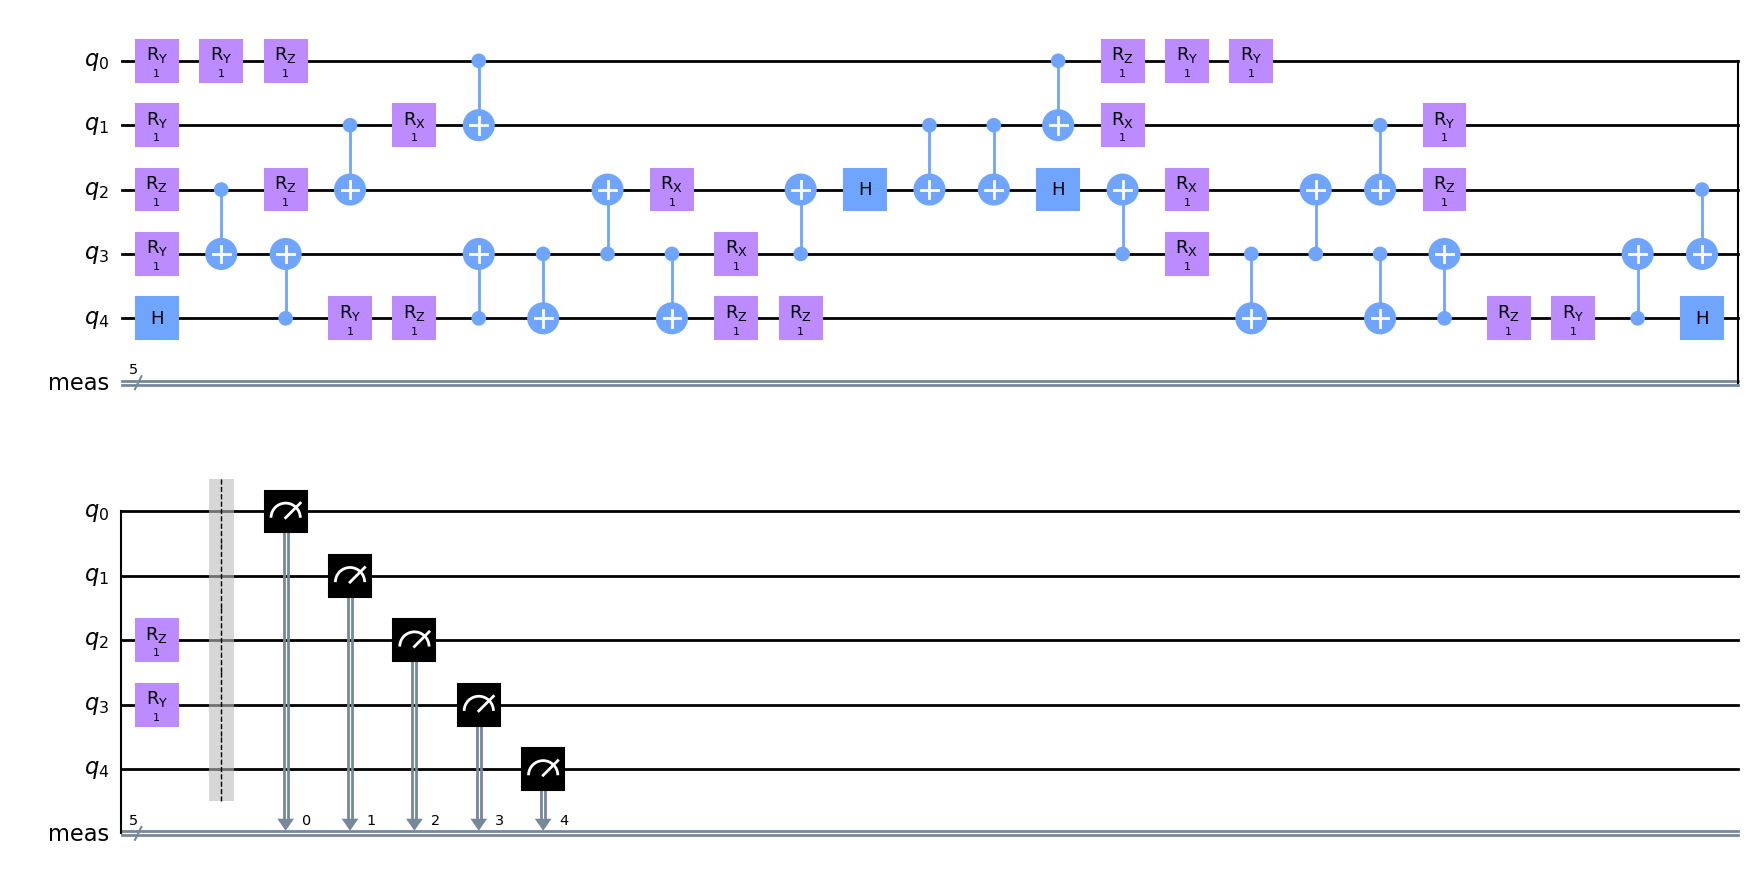

In [15]:
circuit.draw('mpl')

In [14]:
for ele in circuit:
    print(ele)

CircuitInstruction(operation=Instruction(name='ry', num_qubits=1, num_clbits=0, params=[1]), qubits=(Qubit(QuantumRegister(5, 'q'), 0),), clbits=())
CircuitInstruction(operation=Instruction(name='ry', num_qubits=1, num_clbits=0, params=[1]), qubits=(Qubit(QuantumRegister(5, 'q'), 1),), clbits=())
CircuitInstruction(operation=Instruction(name='rz', num_qubits=1, num_clbits=0, params=[1]), qubits=(Qubit(QuantumRegister(5, 'q'), 2),), clbits=())
CircuitInstruction(operation=Instruction(name='ry', num_qubits=1, num_clbits=0, params=[1]), qubits=(Qubit(QuantumRegister(5, 'q'), 3),), clbits=())
CircuitInstruction(operation=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(5, 'q'), 4),), clbits=())
CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(5, 'q'), 2), Qubit(QuantumRegister(5, 'q'), 3)), clbits=())
CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbit

In [13]:
for ele in circuit:
    if len(ele.operation.params) == 1:
        ele.operation.params = [1]
    print(ele.operation.params)


[1]
[1]
[1]
[1]
[]
[]
[]
[1]
[1]
[]
[]
[1]
[1]
[]
[]
[]
[1]
[1]
[1]
[1]
[]
[1]
[]
[]
[]
[]
[]
[]
[1]
[]
[1]
[1]
[1]
[1]
[]
[]
[]
[1]
[1]
[]
[]
[1]
[1]
[]
[]
[]
[1]
[1]
[1]
[1]
[]
[]
[]
[]
[]
[]


In [6]:
circuits = []
for n_gates in range(40,210,10):
    for body_circuit in range(20):
        circuits += random_circuit(5,n_gates, 10, 0.3, True, [[1, 2], [2, 1], [0, 1], [1, 0], [4, 3], [3, 4], [2, 3], [3, 2]], ['h', 'rx','ry','rz'], ['cx', 'cz'] )


In [8]:
trans_circuits = transpile(circuits, backend=backend, optimization_level = 0)

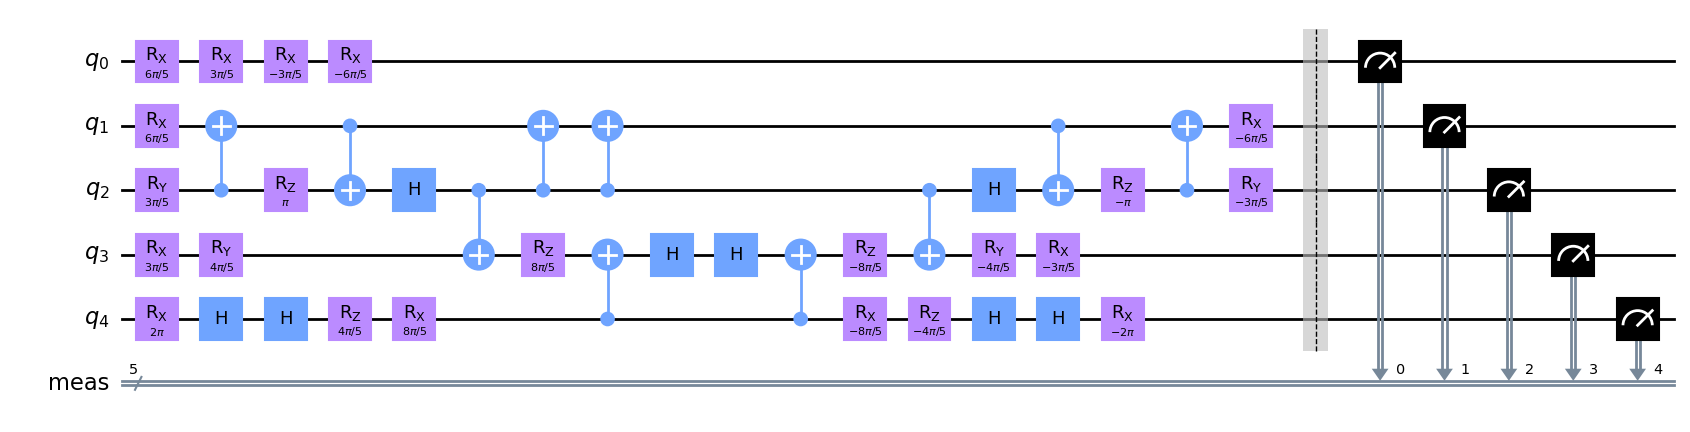

In [13]:
circuits[0].draw()

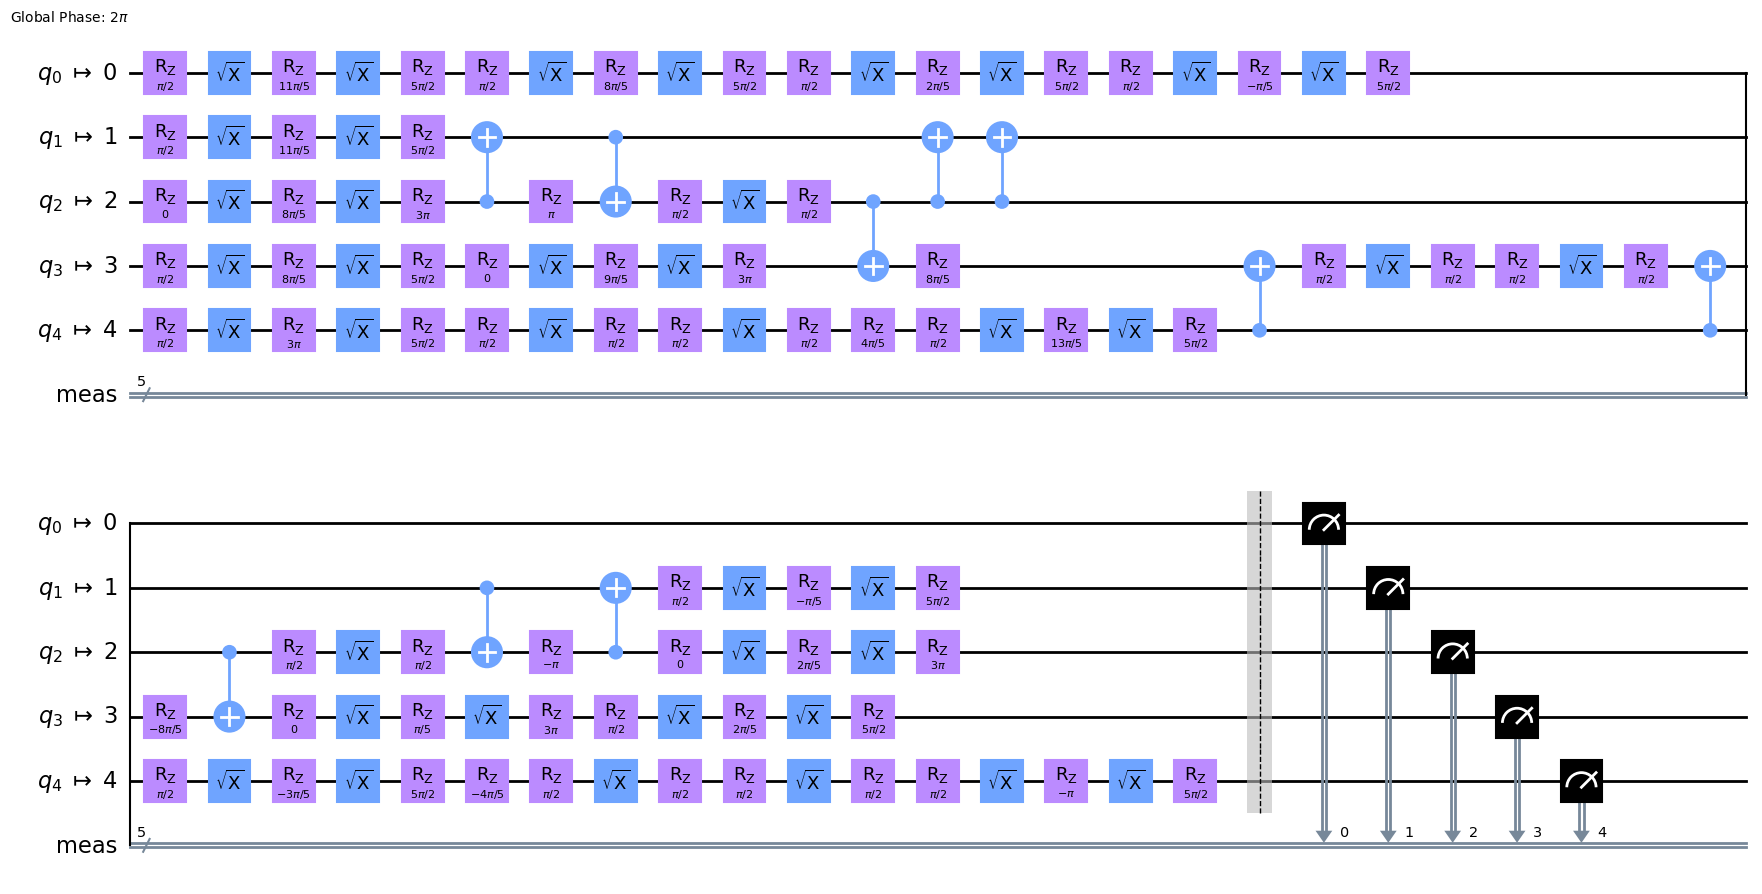

In [14]:
trans_circuits[0].draw()

In [15]:
import pickle 
with open('random_transpiled_circuit_3400.pkl','wb')as f:
    pickle.dump(trans_circuits,f)

In [16]:
job = Sampler("ibmq_manila").run(trans_circuits)
print(f"job id: {job.job_id()}")

job id: cif9if6p0prapsnuklo0


In [14]:
job = service.job('ciekgqc60l54kv8u0i20')
job

<RuntimeJob('ciekgqc60l54kv8u0i20', 'sampler')>

In [6]:
import numpy as np

res = []
for state in job.result().quasi_dists:
    v = np.array(list(state.values()))
    v[np.where(v<0)] = 0
    v = v / np.sum(v)
    k = list(state.keys())
    d = {_k: _v for _k, _v in zip(k, v) if _v != 0}
    res.append(d)

In [7]:
len(res)


3400